In [149]:
import numpy as np 
import random
from scipy.optimize import minimize
from sphere_decoding.sphereDecodingUseC import sphere_decoding_BER
import matplotlib.pyplot as plt
from timeit import default_timer as time

# 交叉熵正常训练


Nt = 2
Nr = 4

iter_num = 30
channel_list = np.load("channel_list_4_2.npy")
H_list = channel_list[0:iter_num]

SNR_list = np.array([25])


alpha = 0.1

max_iter = 1000

pilot_length = 128

beta1 = 0

SD_mean_performance = np.zeros(len(SNR_list))
QNN_mean_performance_128 = np.zeros(len(SNR_list))

save_loss = np.empty((len(SNR_list), iter_num))
save_BER = np.empty((len(SNR_list), iter_num))
save_channel = np.empty((len(SNR_list), iter_num, Nr, Nt), dtype=np.complex128)

In [167]:
# generate signals for simulation
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = [np.array([qam16_modulation(bits_sequence[i+j]) for j in range(Nt)]) for i in range(0, len(bits_sequence), Nt)]
    return bits_sequence, x_sequence

def generate_noise(SNR, Nr):
    return np.sqrt(1/(2*SNR))*(np.random.randn(Nr,1)+1j*np.random.randn(Nr,1))

def generate_data(Nr,Nt,SNR_dB,length,H_channel):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    SNR= 10**(SNR_dB/10)
    n_sequence = [generate_noise(SNR, Nr) for i in range(length)]
    y_sequence = [(np.dot(H_channel, x_sequence[i].reshape(Nt,1)) + n_sequence[i])*np.sqrt(SNR) for i in range(length)]
    return bits_sequence, x_sequence, y_sequence



# training H_hat

def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)

def calculate_layer1_training(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    error_norm = np.empty(dimension_layer1)
    output = np.empty(dimension_layer1)
    # calculate gradient components in layer1
    gradients = np.zeros((dimension_layer1, Nr, Nt), dtype=np.complex128)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        # s_conjugate_transpose = s.conj().T
        error = y - np.dot(H_hat,s)
        error_norm[index] = np.square(np.linalg.norm(error))
        value =  np.exp(-error_norm[index])
        output[index] = value
        gradient_component = np.dot(error, s.conj().T)
        gradients[index] = -value*(-gradient_component)
    # print([np.max(error_norm),np.min(error_norm)])
    return output, gradients

def layer2_matrix(n):
    if n == 1:
        return np.array([0,1])
    else:
        last_ = layer2_matrix(n-1)
        half_cols_num = 2**(n-1)
        first_row = np.concatenate((np.zeros(half_cols_num), np.ones(half_cols_num)))
        remain_rows = np.hstack((last_, last_))
        # print(remain_rows)
        return np.vstack((first_row, remain_rows))


def calculate_layer2_training(layer1_output, true_output):
    total_prob = np.sum(layer1_output)
    # print(total_prob)
    A = layer2_matrix(4*Nt)
    sum_prob_1 = np.dot(A, layer1_output)
    # layer2 output
    output = sum_prob_1/total_prob
    # calculate gradient components in layer2
    gradients = np.zeros(2**(4*Nt))
    # print(output)
    for ii in range(len(gradients)):
        for jj in range(4*Nt):
            gradient1 = true_output[jj]/output[jj]
            gradient2 = (1-true_output[jj])/(1-output[jj])
            gradient3 = A[jj][ii]/total_prob
            gradient4 = sum_prob_1[jj]/np.square(total_prob)
            # gradients for cross entropy
            gradients[ii] += (-1/(4*Nt))*(gradient1-gradient2)*(gradient3-gradient4)
            # gradients for MSE
            # gradients[ii] += (1/(4*Nt))*2*(output[jj]-true_output[jj])*(gradient3-gradient4)

    return output, gradients


def calculate_square_error(layer2_output, true_sequence):
    return np.linalg.norm(layer2_output-true_sequence)**2

def calculate_cross_entropy(layer2_output, true_sequence):
    epsilon = 1e-10  # 为了防止log(0)的情况，添加一个小的常数
    layer2_output = np.clip(layer2_output, epsilon, 1. - epsilon)
    cross_entropy = -np.mean(true_sequence * np.log(layer2_output) + (1 - true_sequence) * np.log(1 - layer2_output))
    return cross_entropy


def calculate_cost_function(H_hat):
    total_loss = 0
    total_gradients = np.zeros((Nr,Nt), dtype=np.complex128)
    training_length = len(y_sequence)
    for ii in range(training_length):
        # print(ii)
        true_sequence = ''.join(bits_sequence[ii*Nt+jj] for jj in range(Nt))
        true_sequence = np.array([eval(ii) for ii in true_sequence])
        layer1_output, layer1_gradients = calculate_layer1_training(H_hat, y_sequence[ii])
        layer2_output, layer2_gradients = calculate_layer2_training(layer1_output, true_sequence)
        total_loss += calculate_cross_entropy(layer2_output,true_sequence)
        # SGD
        if np.random.rand() < 0.9:
            for jj in range(2**(4*Nt)):
                total_gradients += (layer2_gradients[jj]*layer1_gradients[jj])
    mean_loss = total_loss/training_length
    return mean_loss, total_gradients


def training(max_iter):
    H_hat = np.sqrt(1/2)*(np.random.randn(Nr,Nt)+1j*np.random.randn(Nr,Nt))
    # H_hat = np.zeros((Nr,Nt), dtype=np.complex128)
    # H_hat = np.copy(H_w)
    momentum = np.zeros((Nr,Nt),dtype=np.complex128)
    last_loss = -100
    mean_loss = -200
    for iter_num in range(max_iter):
        # solve the gradient
        mean_loss, total_gradients = calculate_cost_function(H_hat)
        print("loss: "+str(mean_loss))
        if np.abs(last_loss-mean_loss) < 0.001:
            return H_hat, mean_loss
        else:
            last_loss = mean_loss
        # update H_hat
        momentum = (1-beta1)*total_gradients + beta1*momentum
        H_hat -= alpha * momentum
        # print(H_hat)
    return H_hat, mean_loss



# testing QNN for detection
def calculate_layer1_testing(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    # layer1 output
    output = np.zeros(dimension_layer1)
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        error = y - np.dot(H_hat,s)
        value =  np.exp(-np.square(np.linalg.norm(error)))
        output[index] = value
    return output

def calculate_layer2_testing(layer1_output):
    total_prob = np.sum(layer1_output)
    # print(total_prob)
    A = layer2_matrix(4*Nt)
    sum_prob_1 = np.dot(A, layer1_output)
    # layer2 output
    output = np.array([sum_prob_1[ii]/total_prob for ii in range(4*Nt)])
    return output

def detection(y, H_trained):
    layer1_output = calculate_layer1_testing(H_trained, y)
    layer2_output = calculate_layer2_testing(layer1_output)
    detect_result = ''
    for ii in range(len(layer2_output)):
        if(layer2_output[ii]>0.5):
            detect_result += '1'
        else:
            detect_result += '0'
    return(detect_result)

def count_differences(str1, str2):
    return sum(a != b for a, b in zip(str1, str2))

def calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing):
    error = 0
    for ii in range(len(y_sequence_testing)):
        detect_result = detection(y_sequence_testing[ii], H_trained)
        true_sequence = ''.join(bits_sequence_testing[ii*Nt+jj] for jj in range(Nt))
        error += count_differences(detect_result, true_sequence)
    BER = error/(len(y_sequence_testing)*len(detect_result))
    return BER

In [168]:
for ii in range(len(SNR_list)):
    SNR_dB = SNR_list[ii]
    SNR = 10**(SNR_dB / 10)
    
    SD_performance = np.zeros(iter_num)
    QNN_performance_128 = np.zeros(iter_num)

    for jj in range(iter_num):
        print("----------------------------current SNR_dB: " +str(SNR_dB))
        print("----------------------------current iter num: " +str(jj))

        H = H_list[jj]

        bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,SNR_dB,1024,H)
        SD_performance[jj] = sphere_decoding_BER(H, y_sequence_testing, bits_sequence_testing, 1)
        print("SD: "+str(SD_performance[jj]))

        H_w = np.copy(H)*np.sqrt(SNR)

        bits_sequence, x_sequence, y_sequence = generate_data(Nr,Nt,SNR_dB,pilot_length,H)
        H_trained, loss = training(max_iter)

        # save_channel[ii][jj] = H_trained
        # save_loss[ii][jj] = loss
        
        
        BER = calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing)

        # save_BER[ii][jj] = BER

        QNN_performance_128[jj] = BER
        print("QNN: "+str(BER))

    SD_mean_performance[ii] = np.mean(SD_performance)
    QNN_mean_performance_128[ii] = np.mean(QNN_performance_128)

----------------------------current SNR_dB: 25
----------------------------current iter num: 0
SD: 0.0
[3064.175796953388, 2646.280397323425]
[2905.476198323196, 2527.0600619374823]
[4861.095588641134, 4364.924625293484]


C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:88: RuntimeWarning: invalid value encountered in divide
  output = sum_prob_1/total_prob
C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:96: RuntimeWarning: invalid value encountered in scalar divide
  gradient3 = A[jj][ii]/total_prob
C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:97: RuntimeWarning: invalid value encountered in scalar divide
  gradient4 = sum_prob_1[jj]/np.square(total_prob)
C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:96: RuntimeWarning: divide by zero encountered in scalar divide
  gradient3 = A[jj][ii]/total_prob


[1657.2221515616152, 1461.3858642493128]
[4524.053775295336, 4057.1041661520444]
[1291.9035444316964, 1105.7532460531402]
[4208.616413967217, 3758.1337342915544]
[2786.4511019081438, 2371.9421083411835]
[5138.747639266315, 4671.1488732708185]
[5653.745088295319, 5180.573081291715]
[4025.0041736799913, 3617.5371490834523]
[3320.6914227747384, 2892.374078389082]
[4561.388226710353, 4218.0632794535495]
[2635.1781133573663, 2239.4013004517174]
[3264.9549109432705, 2875.032193751]
[2882.234429114959, 2446.9877595797334]
[4829.451874775937, 4346.323787324922]
[5579.720159066755, 5073.49116119397]
[7230.11618554709, 6695.027987517934]
[3442.2631228190025, 3027.526561789384]
[2387.3329885493013, 2184.716252337434]
[1666.5208068189204, 1471.8621903594699]
[3134.6764675116174, 2760.3092137691583]
[1237.3684629917077, 1067.1946744705072]
[3128.131294494144, 2752.764634731625]
[1376.9313374741982, 1223.821218004309]
[5105.325636632087, 4639.071695219559]
[1574.589248193282, 1382.2155022167624]
[33

C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  gradient4 = sum_prob_1[jj]/np.square(total_prob)
C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:99: RuntimeWarning: invalid value encountered in scalar add
  gradients[ii] += (-1/(4*Nt))*(gradient1-gradient2)*(gradient3-gradient4)
C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:95: RuntimeWarning: invalid value encountered in scalar divide
  gradient2 = (1-true_output[jj])/(1-output[jj])


[1336.248822243694, 1179.1801497732943]
[847.1438585252802, 670.6284680949152]
[4068.6092591150314, 3650.3271586559144]
[2680.483086107327, 2272.16057279909]
[3335.8725870842236, 2923.2318659331363]
[3376.4756532914025, 2952.781715970676]
[1598.632391983383, 1415.9531542590319]
[6464.278173278058, 5948.376095761912]
[3903.914397554962, 3470.4971729713034]
[898.4717338664635, 702.687341582651]


C:\Users\29265\AppData\Local\Temp\ipykernel_21784\1789842853.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  gradient2 = (1-true_output[jj])/(1-output[jj])


[4209.845028841245, 3769.206150070825]
[5185.2092949322605, 4696.671958534]
[5283.920051993862, 4805.770699427128]
[3215.8788515582683, 2802.692240045265]
[1358.3585483680918, 1172.917213163935]
[3668.560822704812, 3210.1011440413986]
[5715.585142160087, 5239.003549977582]
[4138.502100734347, 3789.738292060618]
[3065.499730685815, 2678.8424728160207]
[3960.970710052216, 3536.824731662496]
[4629.146692702938, 4141.438387022252]
[3292.8254494718503, 2865.067759140207]
[5221.232895586573, 4735.952745533645]
[4306.349125978179, 3941.7258454354446]
[6217.646981383657, 5713.636924352757]
[2083.7182942871627, 1890.4424956366588]
[3140.7800425144746, 2758.3134199406422]
[3588.868804106731, 3133.5370660165263]
[1525.7600587051309, 1340.5359022308387]
[653.8771899015231, 484.6251599758896]
[4107.066813606903, 3670.0310577207906]
[3653.050787035512, 3284.0376495917644]
[5540.90926481977, 5079.703445581554]
[4761.339079461227, 4278.150176164476]
[1594.683493150329, 1378.5786332166706]
[3134.418287

KeyboardInterrupt: 

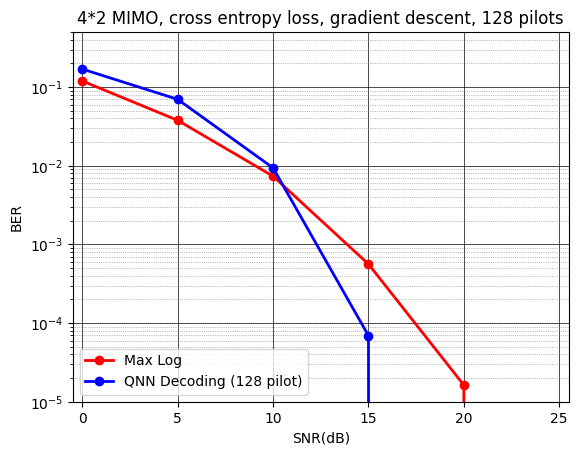

In [26]:
import matplotlib.ticker as ticker
fig = plt.figure()

ax1 = fig.add_subplot(111)

lns1 = ax1.plot(SNR_list, SD_mean_performance, '-ro', linewidth=2.0, label="Max Log")
lns2 = ax1.plot(SNR_list, QNN_mean_performance_128, '-bo', linewidth=2.0, label="QNN Decoding (128 pilot)")



lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")

ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto'))
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

ax1.set_xticks(SNR_list)
ax1.set_yscale("log")
ax1.set_adjustable("datalim")
ax1.set_xlim(-0.5,25.5)
ax1.set_ylim(1e-5, 0.5)
ax1.set_ylabel("BER")
ax1.set_xlabel("SNR(dB)")
plt.title("4*2 MIMO, cross entropy loss, gradient descent, 128 pilots")

plt.savefig('BER.png',dpi=600, bbox_inches='tight')
plt.show()

In [37]:
save_channel[0][0]

array([[-0.42285545+0.62606458j, -0.84648585-1.90772263j],
       [-0.87646608+0.83763628j, -1.37942579+0.91253003j],
       [ 0.57674952+0.97768131j,  0.50516082-0.45890055j],
       [-0.27671069+0.05670283j,  0.13824529+1.48844958j]])

In [162]:
bits2signals('11011111')

array([[-0.31622777-0.9486833j],
       [-0.9486833 -0.9486833j]])